In [1]:
library(WGCNA)
library(tidyverse)
library(ComplexHeatmap)
library(repr)
library(circlize)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [5]:
# macs2 compute signal: since it is normalized to internal control, 
# the quantification is expected to be more robust for technical variance (noise, batch)
signal_profile <- read.csv("NFKB_ND_FC_Signal_at_Consensus_Peaks.txt", sep="\t")
# peak coordinates as row name
rownames(signal_profile) <- paste(signal_profile$Chromosome, signal_profile$Start, signal_profile$End, sep=",")
signal_profile <- signal_profile[, 4:ncol(signal_profile)]
# log scale to stablize variance and more close to normal distribution
log2_signal <- log2(signal_profile + 1)
# filter low count ATAC peaks
log2_signal <- log2_signal[rowSums(log2_signal > log2(4+1)) >  0.5 * ncol(log2_signal), ]

# standardize
filtered <- t(apply(log2_signal, 1, function(x) {
    std <- sd(x)
    if (std==0) {
        std <- NA 
    }
    (x-mean(x)) / std
}))
filtered <- filtered[complete.cases(filtered), ]
normalized_counts <- t(filtered)
dim(normalized_counts)

[1]    29 33649

In [3]:
# choose soft power to optimize network structure
powers = c(c(1:10), seq(from = 12, to = 30, by = 2))
sft <- pickSoftThreshold(normalized_counts, dataIsExpr = TRUE, powerVector = powers, networkType = "signed", corFnc = "bicor")

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.8400  8.460          0.955 20300.0  20700.00  23800
2      2   0.5580  3.000          0.885 12800.0  13100.00  17500
3      3   0.1530  1.000          0.793  8350.0   8540.00  13200
4      4   0.0106  0.221          0.811  5610.0   5660.00  10300
5      5   0.0320 -0.355          0.833  3860.0   3810.00   8080
6      6   0.1650 -0.782          0.868  2710.0   2610.00   6460
7      7   0.3260 -1.110          0.901  1940.0   1810.00   5230
8      8   0.4630 -1.330          0.929  1410.0   1270.00   4270
9      9   0.5610 -1.530          0.941  1040.0    900.00   3530
10    10   0.6330 -1.680          0.951   781.0    645.00   2950
11    12   0.7100 -1.900          0.959   453.0    341.00   2100
12    14   0.7570 -2.010          0.967   273.0    186.00   1530
13    16   0.7900 -2.070          0.974   171.0    105.00   1140
14    18   0.8100 -2.100          0.977   110.0     61.10    863
15    20   0.8310 -2.100 

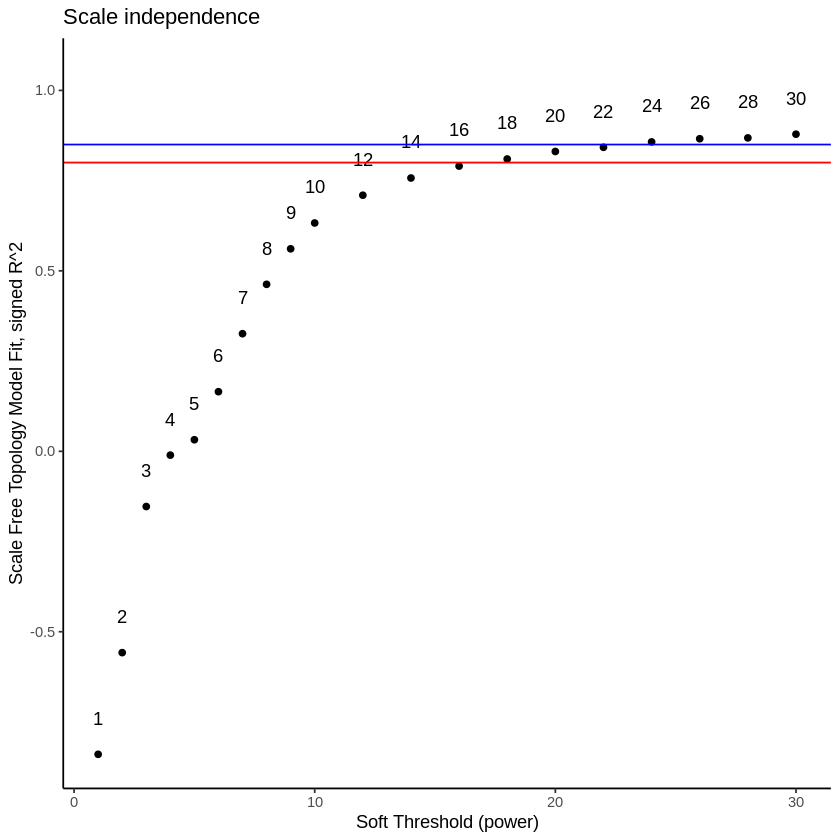

In [4]:
sft_df <- data.frame(sft$fitIndices) %>%
      dplyr::mutate(model_fit = -sign(slope) * SFT.R.sq)

ggplot(sft_df, aes(x = Power, y = model_fit, label = Power)) +
      # Plot the points
      geom_point() +
      # We'll put the Power labels slightly above the data points
      geom_text(nudge_y = 0.1) +
      # We will plot what WGCNA recommends as an R^2 cutoff
      geom_hline(yintercept = 0.80, col = "red") +
      geom_hline(yintercept = 0.85, col = "blue") +
      # Just in case our values are low, we want to make sure we can still see the 0.80 level
      ylim(c(min(sft_df$model_fit), 1.05)) +
      # We can add more sensible labels for our axis
      xlab("Soft Threshold (power)") +
      ylab("Scale Free Topology Model Fit, signed R^2") +
      ggtitle("Scale independence") +
      # This adds some nicer aesthetics to our plot
      theme_classic()

In [6]:
softPower = 22
adjacency = adjacency(normalized_counts, power = softPower, type = "signed")
# Turn adjacency into topological overlap
TOM = TOMsimilarity(adjacency, TOMType = "signed")
dissTOM = 1-TOM
# Call the hierarchical clustering function
geneTree = hclust(as.dist(dissTOM), method = "average")
# geneTree = hclust(as.dist(dissTOM), method = "ward.D2")

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [7]:
# We like large modules, so we set the minimum module size relatively high:
minModuleSize = 100
# Module identification using dynamic tree cut:
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
    deepSplit = 2, pamRespectsDendro = FALSE,
    minClusterSize = minModuleSize);
# Convert numeric lables into colors
dynamicColors = labels2colors(dynamicMods)
table(dynamicMods)

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
  74 7070 4578 3840 1927 1790 1737 1502 1297 1079  918  804  765  756  669  601 
  16   17   18   19   20   21   22   23   24   25   26   27 
 516  508  450  433  400  400  375  330  268  248  187  127 

In [15]:
# table(dynamicColors)
# Plot the dendrogram and colors underneath
# plotDendroAndColors(geneTree, merge$color, "Dynamic Tree Cut",
#     dendroLabels = FALSE, hang = 0.03,
#     addGuide = TRUE, guideHang = 0.05,
#     main = "Gene dendrogram and module colors")

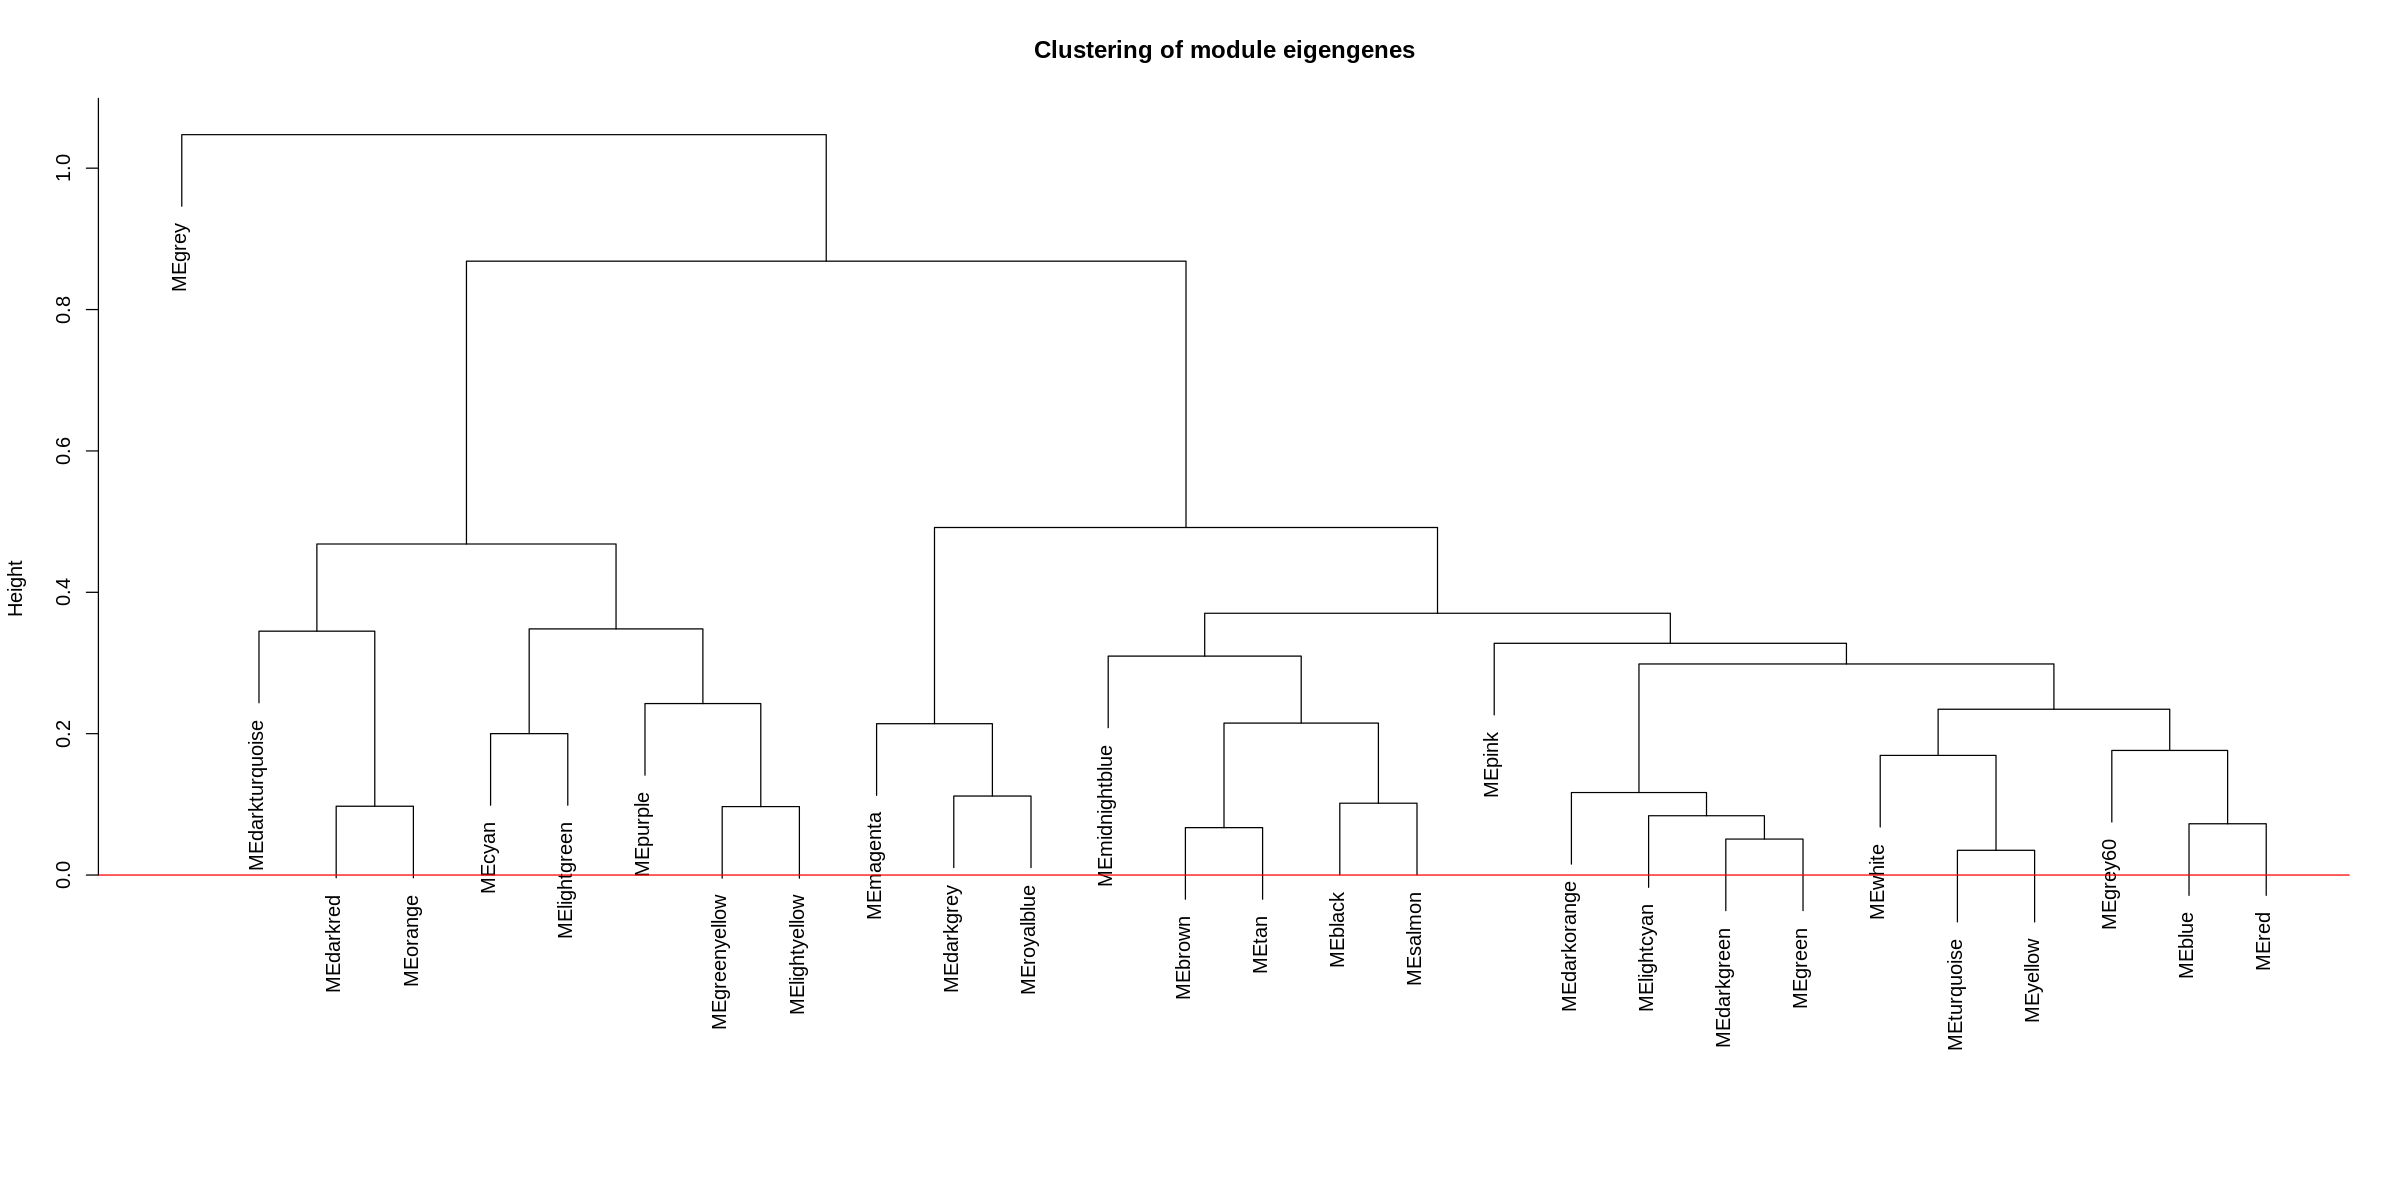

In [8]:
# Calculate eigengenes
MEList = moduleEigengenes(normalized_counts, colors = dynamicColors)
MEs = MEList$eigengenes
MEDiss = 1-cor(MEs)
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average")
# Plot the cut line into the dendrogram
options(repr.plot.width=20, repr.plot.height=10)
plot(METree, main = "Clustering of module eigengenes", xlab = "", sub = "")
MEDissThres = 0
abline(h=MEDissThres, col = "red")

In [9]:
# Call an automatic merging function
merge = mergeCloseModules(normalized_counts, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs
table(merge$color)

 mergeCloseModules: Merging modules whose distance is less than 0
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 28 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 28 module eigengenes in given set.



        black          blue         brown          cyan     darkgreen 
         1502          4578          3840           669           375 
     darkgrey    darkorange       darkred darkturquoise         green 
          268           187           400           330          1790 
  greenyellow          grey        grey60     lightcyan    lightgreen 
          804            74           508           516           450 
  lightyellow       magenta  midnightblue        orange          pink 
          433          1079           601           248          1297 
       purple           red     royalblue        salmon           tan 
          918          1737           400           756           765 
    turquoise         white        yellow 
         7070           127          1927 

# Analyze Modules

In [19]:
options(repr.plot.width=20, repr.plot.height=20)
n_samples <- ncol(filtered)
cor_mat <- cor(filtered)
colha <- HeatmapAnnotation(
    df=mergedMEs,
    which="col",
    simple_anno_size = unit(10, "mm")
)

sample_heatmap <- Heatmap(1-cor_mat, row_dend_width = n_samples * unit(2, "mm"), column_dend_height  = n_samples * unit(2, "mm"),
        # col=colorRamp2(c(-.5, 0, .5), c("blue", "white", "red")), 
        top_annotation = colha)

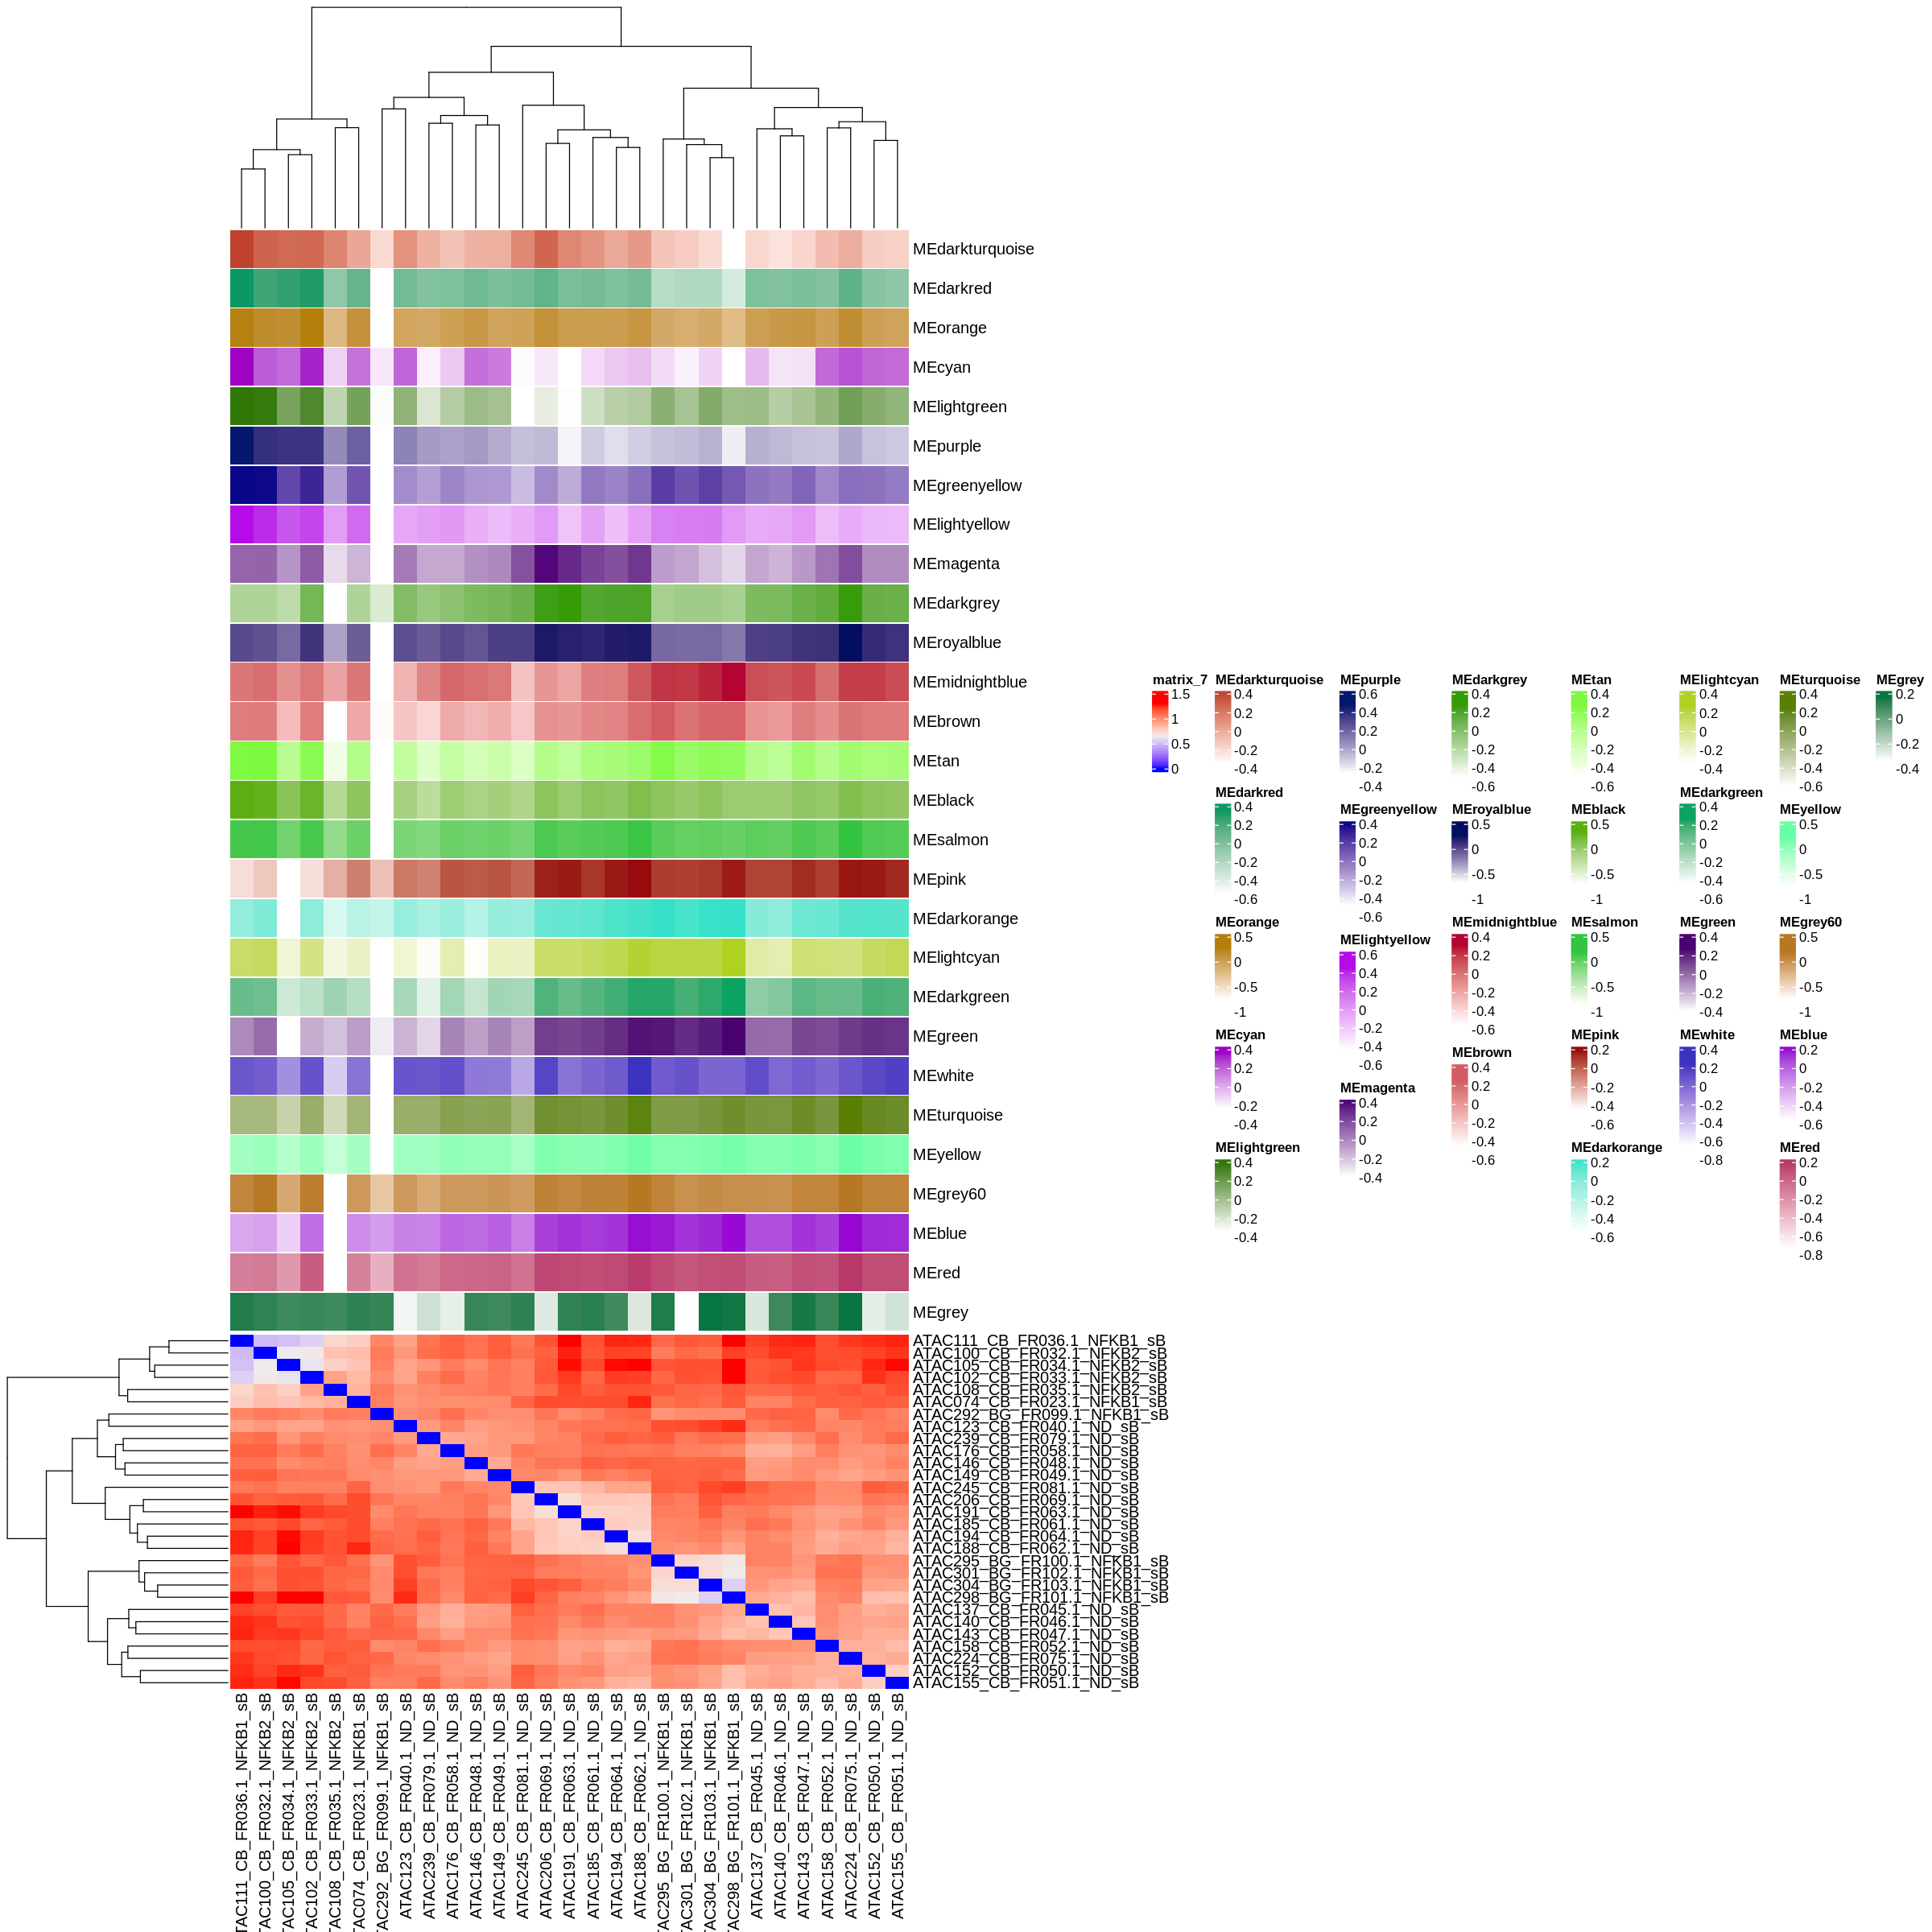

In [20]:
draw(sample_heatmap)

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The input is a data frame, convert it to a matrix.”


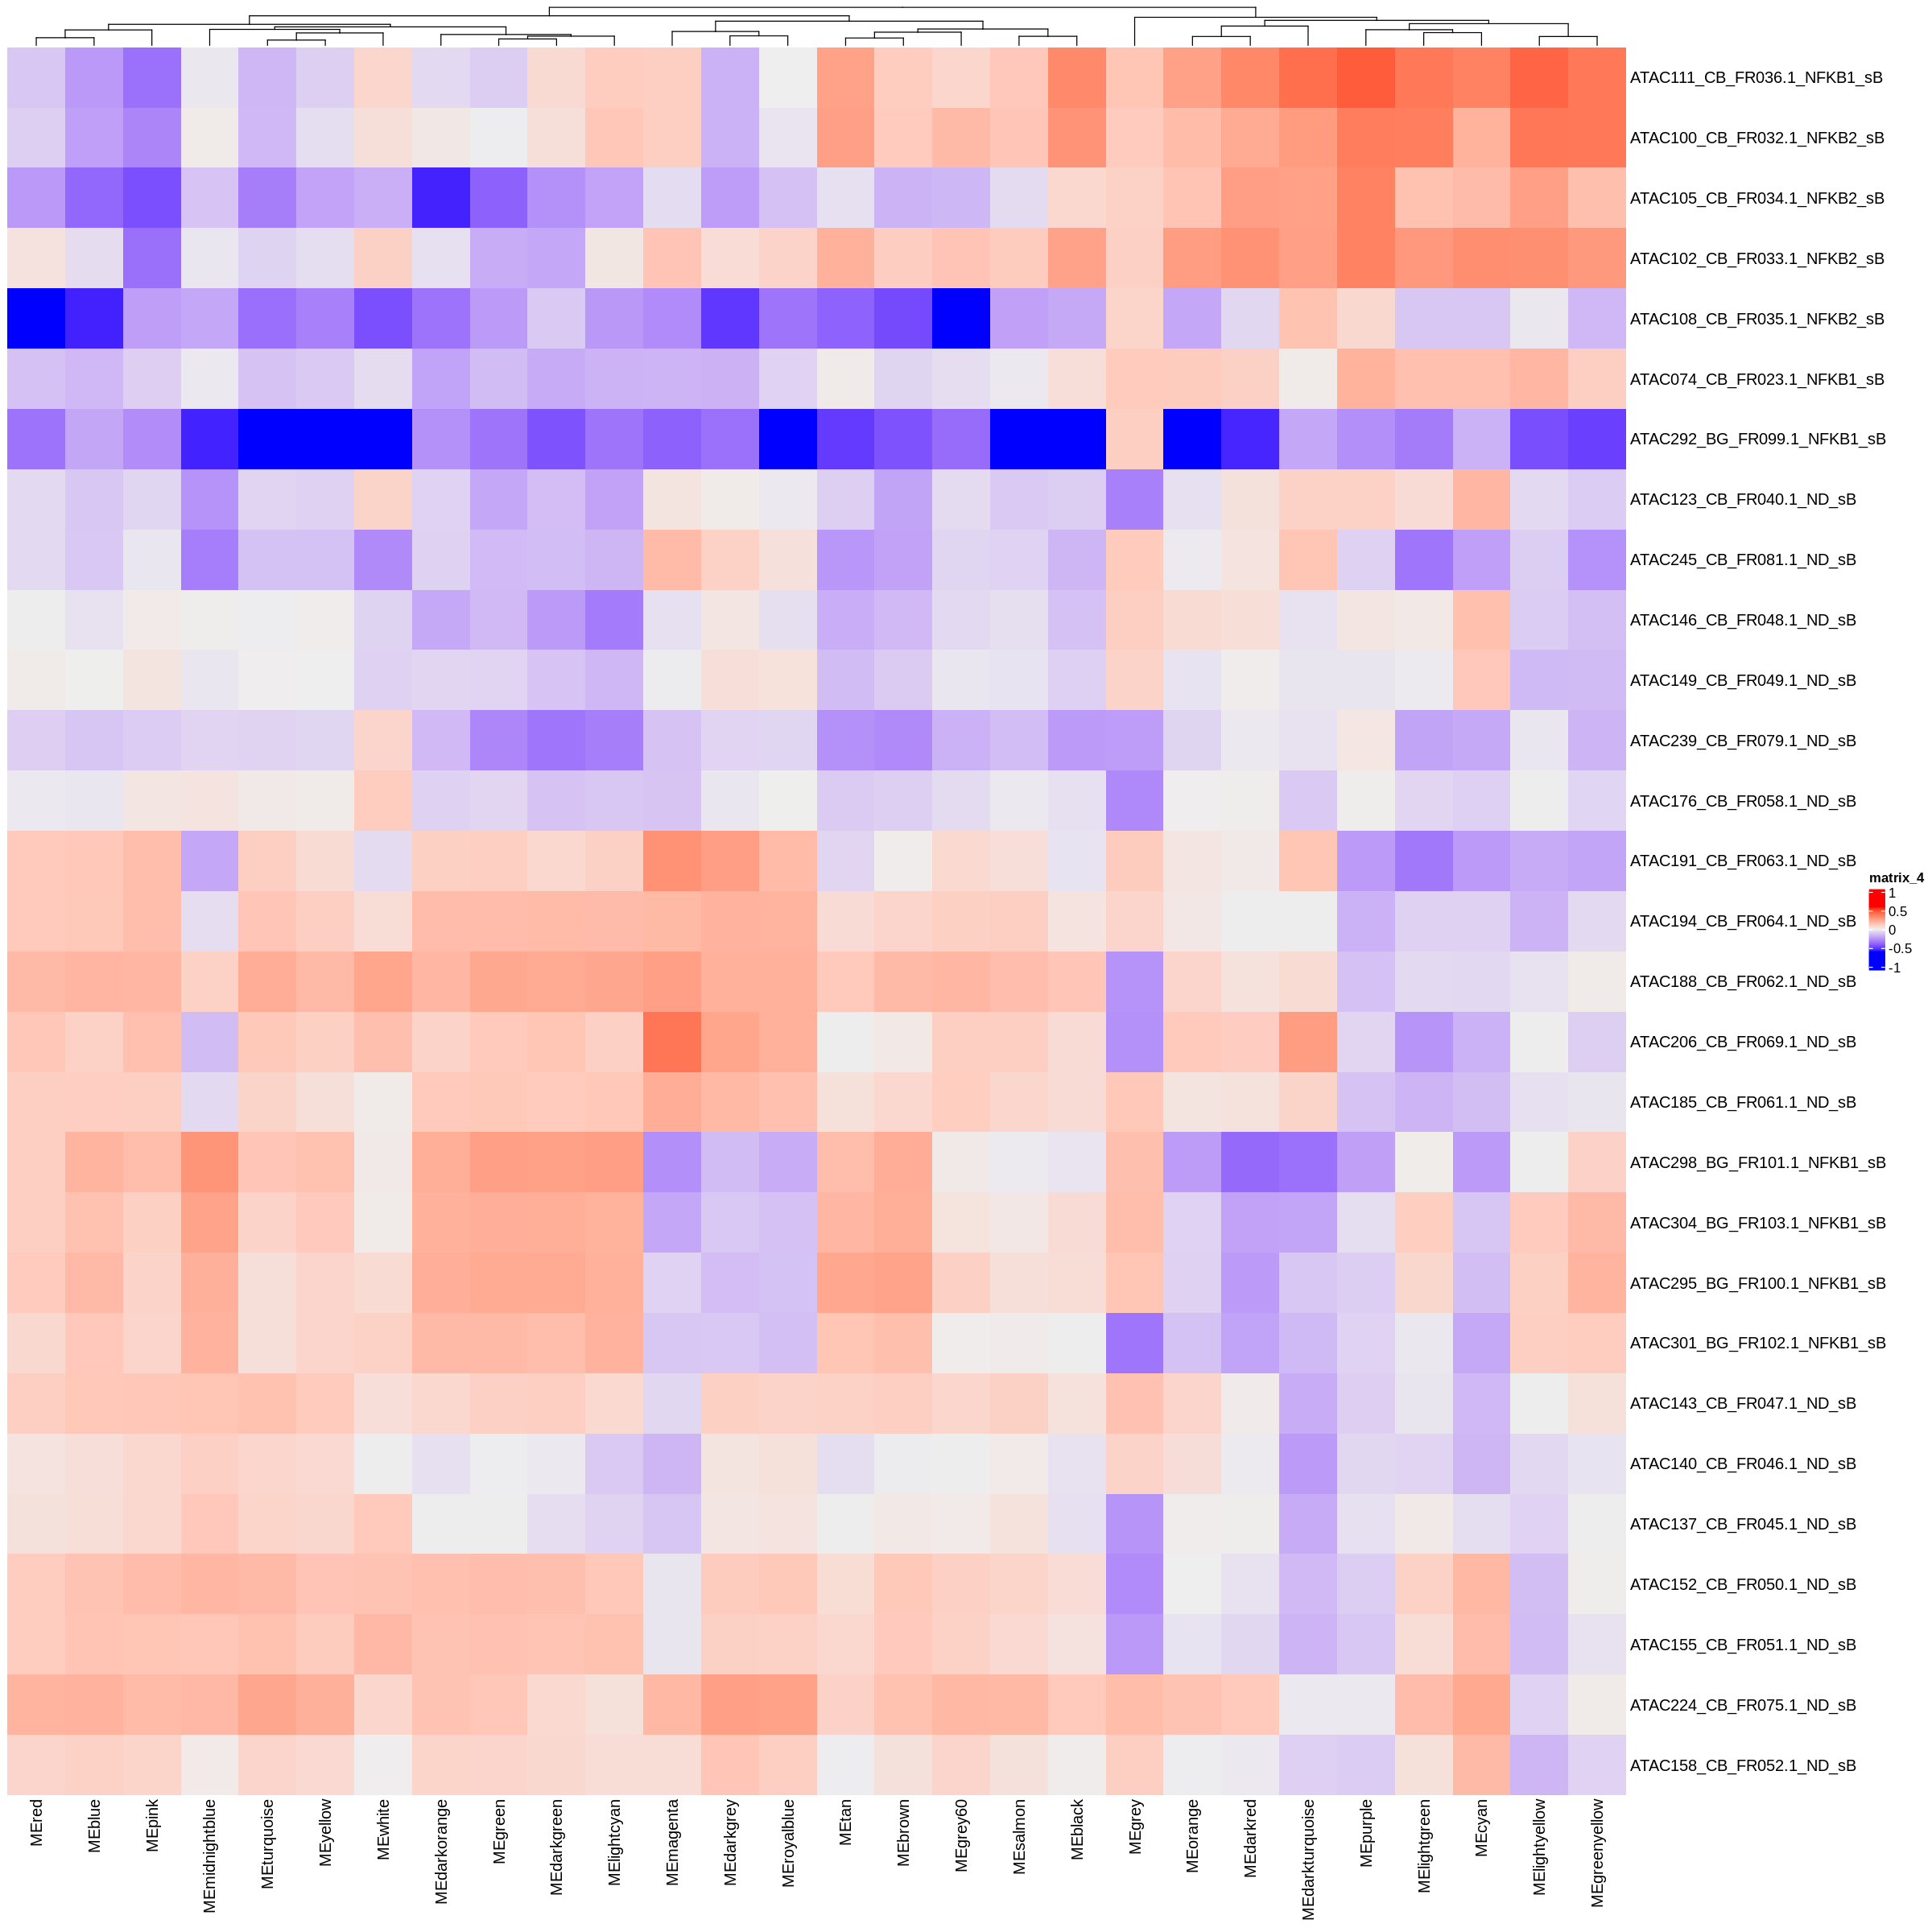

In [13]:
Heatmap(mergedMEs[rownames(cor_mat)[row_order(sample_heatmap)], ], cluster_rows = FALSE)

In [87]:
table(merge$color)


       brown         cyan     darkgrey      darkred  greenyellow         grey 
       26023         2127          772          334         2555           30 
midnightblue       purple 
         698         1110 